<a href="https://colab.research.google.com/github/thisishasan/data_mining_and_machine_learning/blob/main/data_mining_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -nc -O dataset.csv 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.tree import ExtraTreeRegressor

In [ ]:
!pip -q install tslearn

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from typing import List, Tuple, Dict, Any

In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

In [ ]:
df = df.drop(columns=['Unnamed: 4'])
display(df.head())

In [ ]:
display(df.tail())

In [ ]:
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows in country_domestic_aviation_df: {len(duplicate_rows)}")
if not duplicate_rows.empty:
    display(duplicate_rows.head())

In [ ]:
print("\nCheck Null values:")
display(df.isnull().sum())

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.head()

In [ ]:
df.info()

In [ ]:
df = df[~df["country"].isin(["WORLD", "EU27", "ROW"])].copy()

In [ ]:
unique_countries = df['country'].unique()
print("Unique Countries:")
for country in unique_countries:
    print(f"- {country}")

In [ ]:
unique_sectors = df['sector'].unique()
print("\nUnique Sectors:")
for sector in unique_sectors:
    print(f"- {sector}")

In [ ]:
italy_df = df[df['country'] == 'Italy']
display(italy_df.head())

In [ ]:
italy_df.info()

In [ ]:
italy_sector_counts = italy_df.groupby('sector').size().reset_index(name='count')
display(italy_sector_counts)

In [ ]:
# duplicate_italy_rows = italy_df[italy_df.duplicated(keep=False)]
# print(f"Number of duplicate rows in Italy data: {len(duplicate_italy_rows)}")

In [ ]:
italy_domestic_aviation_df = italy_df[italy_df['sector'] == 'Domestic Aviation']
display(italy_domestic_aviation_df.head())

In [ ]:
italy_domestic_aviation_df['value'].describe()

In [ ]:
italy_domestic_aviation_df = italy_domestic_aviation_df.sort_values(by='date')
italy_domestic_aviation_df['delta'] = italy_domestic_aviation_df['date'] - italy_domestic_aviation_df['date'].shift(1)

display(italy_domestic_aviation_df[['date', 'delta']].head())
display(italy_domestic_aviation_df['delta'].sum(), italy_domestic_aviation_df['delta'].count())

In [ ]:
italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['delta', 'country','sector'], errors='ignore')
display(italy_domestic_aviation_df.head())

In [ ]:
# italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['country','sector'], errors='ignore')
# display(italy_domestic_aviation_df.head())

In [ ]:
# print("Null values in Domestic Aviation DataFrame:")
# display(italy_domestic_aviation_df.isnull().sum())

In [ ]:
# italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
# display(italy_domestic_aviation_df.head())

In [ ]:
# italy_domestic_aviation_monthy_df = italy_domestic_aviation_df[['date','value']].resample('ME', on='date').mean()
# display(italy_domestic_aviation_monthy_df.info())

In [ ]:
italy_domestic_aviation_df = italy_domestic_aviation_df.set_index('date')
display(italy_domestic_aviation_df.info())
display(italy_domestic_aviation_df.head(5))

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue')
plt.ylabel("CO₂ Emissions")
plt.xlabel('Per Day')
plt.title("Figure 1: Line Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue')
plt.tight_layout()
plt.ylabel("CO₂ Emissions")
plt.xlabel('Per Day')
plt.title("Figure 2: Scatter Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

In [ ]:
def visualize_regime_segments(time_series,
                              change_points=None,
                              plot_title="Time Series Regime Segmentation"):

    data_series = time_series.dropna().sort_index()

    if change_points is None:
        change_points = []
    else:
        change_points = [pd.to_datetime(cp) for cp in change_points]

    valid_changes = sorted(
        [cp for cp in change_points
         if data_series.index.min() < cp < data_series.index.max()]
    )

    segment_limits = [data_series.index.min()] + valid_changes + [data_series.index.max()]

    plt.figure(figsize=(18, 6))
    plt.plot(data_series.index,
             data_series.values,
             linewidth=1,
             label="Observed Series", color="blue")

    for cp in valid_changes:
        plt.axvline(cp,
                    linestyle="--",
                    linewidth=1)

    for idx in range(len(segment_limits) - 1):

        start_date = segment_limits[idx]
        end_date   = segment_limits[idx + 1]

        segment_data = data_series.loc[
            (data_series.index >= start_date) &
            (data_series.index < end_date)
        ]

        if segment_data.empty:
            continue

        segment_mean = segment_data.mean()

        print(f"Segment Mean {idx + 1}: {segment_mean}")

        plt.hlines(segment_mean,
                   xmin=segment_data.index.min(),
                   xmax=segment_data.index.max(),
                   linewidth=3,
                   color="red",
                   label="Segment Mean" if idx == 0 else None)

    plt.title(plot_title)
    plt.xlabel("Per Day")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
breaks = ["2020-03-01", "2022-02-01"]

In [ ]:
visualize_regime_segments(italy_domestic_aviation_df["value"], breaks, plot_title="Figure 3: Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025, regimes + mean levels")

In [ ]:
def visualize_piecewise_linear_fit(series_input,
                                   change_dates=None,
                                   figure_title="Segmented Linear Trend"):

    cleaned_series = series_input.dropna().sort_index()

    if change_dates is None:
        change_dates = []
    else:
        change_dates = [pd.to_datetime(dt) for dt in change_dates]

    valid_points = sorted(
        [dt for dt in change_dates
         if cleaned_series.index.min() < dt < cleaned_series.index.max()]
    )

    interval_edges = [cleaned_series.index.min()] + valid_points + [cleaned_series.index.max()]

    plt.figure(figsize=(18, 6))
    plt.plot(cleaned_series.index,
             cleaned_series.values,
             linewidth=1,
             label="Observed Data",
             color="blue")

    for dt in valid_points:
        plt.axvline(dt,
                    linestyle="--",
                    linewidth=1)

    for j in range(len(interval_edges) - 1):

        start_bound = interval_edges[j]
        end_bound   = interval_edges[j + 1]

        segment_series = cleaned_series.loc[
            (cleaned_series.index >= start_bound) &
            (cleaned_series.index < end_bound)
        ]

        if len(segment_series) < 5:
            continue

        time_index = (segment_series.index - segment_series.index.min()).days.astype(float)
        values = segment_series.values.astype(float)

        slope, intercept = np.polyfit(time_index, values, 1)
        fitted_values = intercept + slope * time_index

        plt.plot(segment_series.index,
                 fitted_values,
                 linewidth=3,
                 color="green",
                 label="Segment Linear Trend" if j == 0 else None)

    plt.title(figure_title)
    plt.xlabel("Per Day")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_piecewise_linear_fit(italy_domestic_aviation_df["value"], breaks,
                     figure_title="Figure 4: Italy's Domestic Aviation CO₂ Emissions | From January 1st, 2019 to November 30th, 2025 | Regimes Trends")


In [ ]:
# mean = np.mean(italy_domestic_aviation_df['value'])
# print("Median:", mean)

In [ ]:
# median = np.median(italy_domestic_aviation_df['value'])
# print("Median:", median)

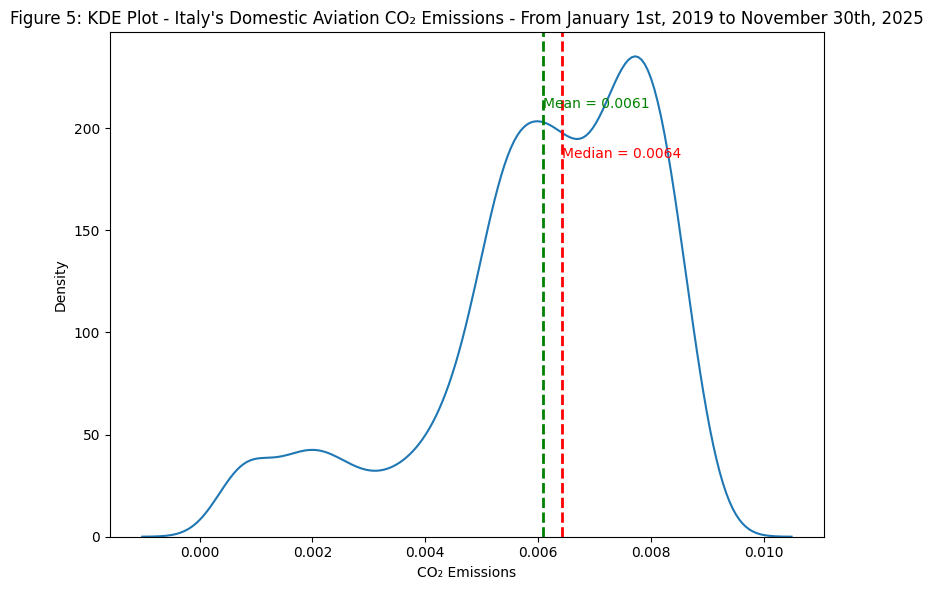

In [773]:
avg_emission = italy_domestic_aviation_df["value"].mean()
median_emission = italy_domestic_aviation_df["value"].median()

plt.figure(figsize=(8, 6))

sns.kdeplot(italy_domestic_aviation_df["value"])

plt.grid(False)

upper_density_limit = plt.ylim()[1]

plt.axvline(avg_emission,
            color="green",
            linestyle="--",
            linewidth=2)

plt.text(avg_emission,
         upper_density_limit * 0.85,
         f"Mean = {avg_emission:.4f}",
         color="green",
         ha="left")

plt.axvline(median_emission,
            color="red",
            linestyle="--",
            linewidth=2)

plt.text(median_emission,
         upper_density_limit * 0.75,
         f"Median = {median_emission:.4f}",
         color="red",
         ha="left")

plt.xlabel("CO₂ Emissions")
plt.ylabel("Density")
plt.title("Figure 5: KDE Plot - Italy's Domestic Aviation CO₂ Emissions - From January 1st, 2019 to November 30th, 2025")

plt.tight_layout()
plt.show()

In [774]:
def plot_seasonal_pattern(data_frame,
                          season_unit='year',
                          period_unit='month',
                          value_column=None,
                          plot_title = ""):

    if value_column is None:
        value_column = data_frame.columns[0]

    period_values = getattr(data_frame.index, period_unit)
    season_values = getattr(data_frame.index, season_unit)

    seasonal_table = pd.pivot_table(
        data_frame,
        index=period_values,
        columns=season_values,
        values=value_column
    )

    seasonal_table.plot(figsize=(12, 8))

    plt.title(plot_title)
    plt.xlabel("Per Month")
    plt.ylabel("CO₂ Emissions")
    plt.legend(title=season_unit.capitalize())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

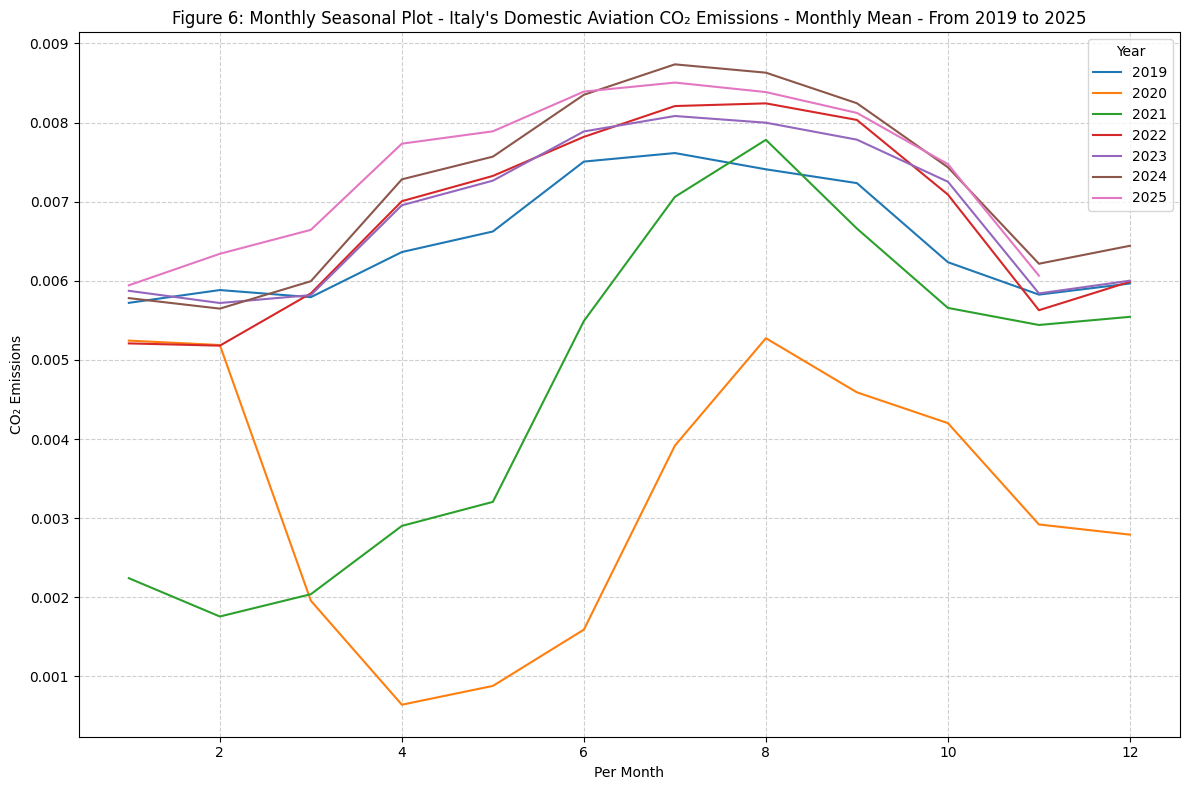

In [775]:
italy_domestic_aviation_df['year'] = italy_domestic_aviation_df.index.year
italy_domestic_aviation_df['month'] = italy_domestic_aviation_df.index.month

plot_seasonal_pattern(italy_domestic_aviation_df, season_unit='year', period_unit='month', value_column='value', plot_title="Figure 6: Monthly Seasonal Plot - Italy's Domestic Aviation CO₂ Emissions - Monthly Mean - From 2019 to 2025")

In [776]:
def monthly_subseries_visualization(input_df,
                                     month_field='month',
                                     year_field='year',
                                     emission_field='value',
                                     plot_title=""):

    monthly_summary = (
        input_df
        .groupby([month_field, year_field])[emission_field]
        .mean()
        .reset_index()
    )

    fig, subplot_array = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
    subplot_array = subplot_array.flatten()
    fig.suptitle(plot_title, fontsize=16)

    month_names_list = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    for position, month_number in enumerate(range(1, 13)):
        current_axis = subplot_array[position]

        monthly_data = monthly_summary[
            monthly_summary[month_field] == month_number
        ]

        sns.lineplot(
            x=year_field,
            y=emission_field,
            data=monthly_data,
            ax=current_axis,
            marker='o'
        )

        overall_month_avg = monthly_data[emission_field].mean()

        current_axis.axhline(
            overall_month_avg,
            color='red',
            linestyle='--',
            linewidth=1.5,
            label=f'Mean: {overall_month_avg:.3f}'
        )

        current_axis.set_title(month_names_list[month_number - 1])
        current_axis.tick_params(axis='x', rotation=45)
        current_axis.set_xlabel('Year')
        current_axis.set_ylabel('CO₂ Emissions')
        current_axis.grid(True, linestyle='--', alpha=0.6)
        current_axis.legend()

    plt.tight_layout()
    plt.show()

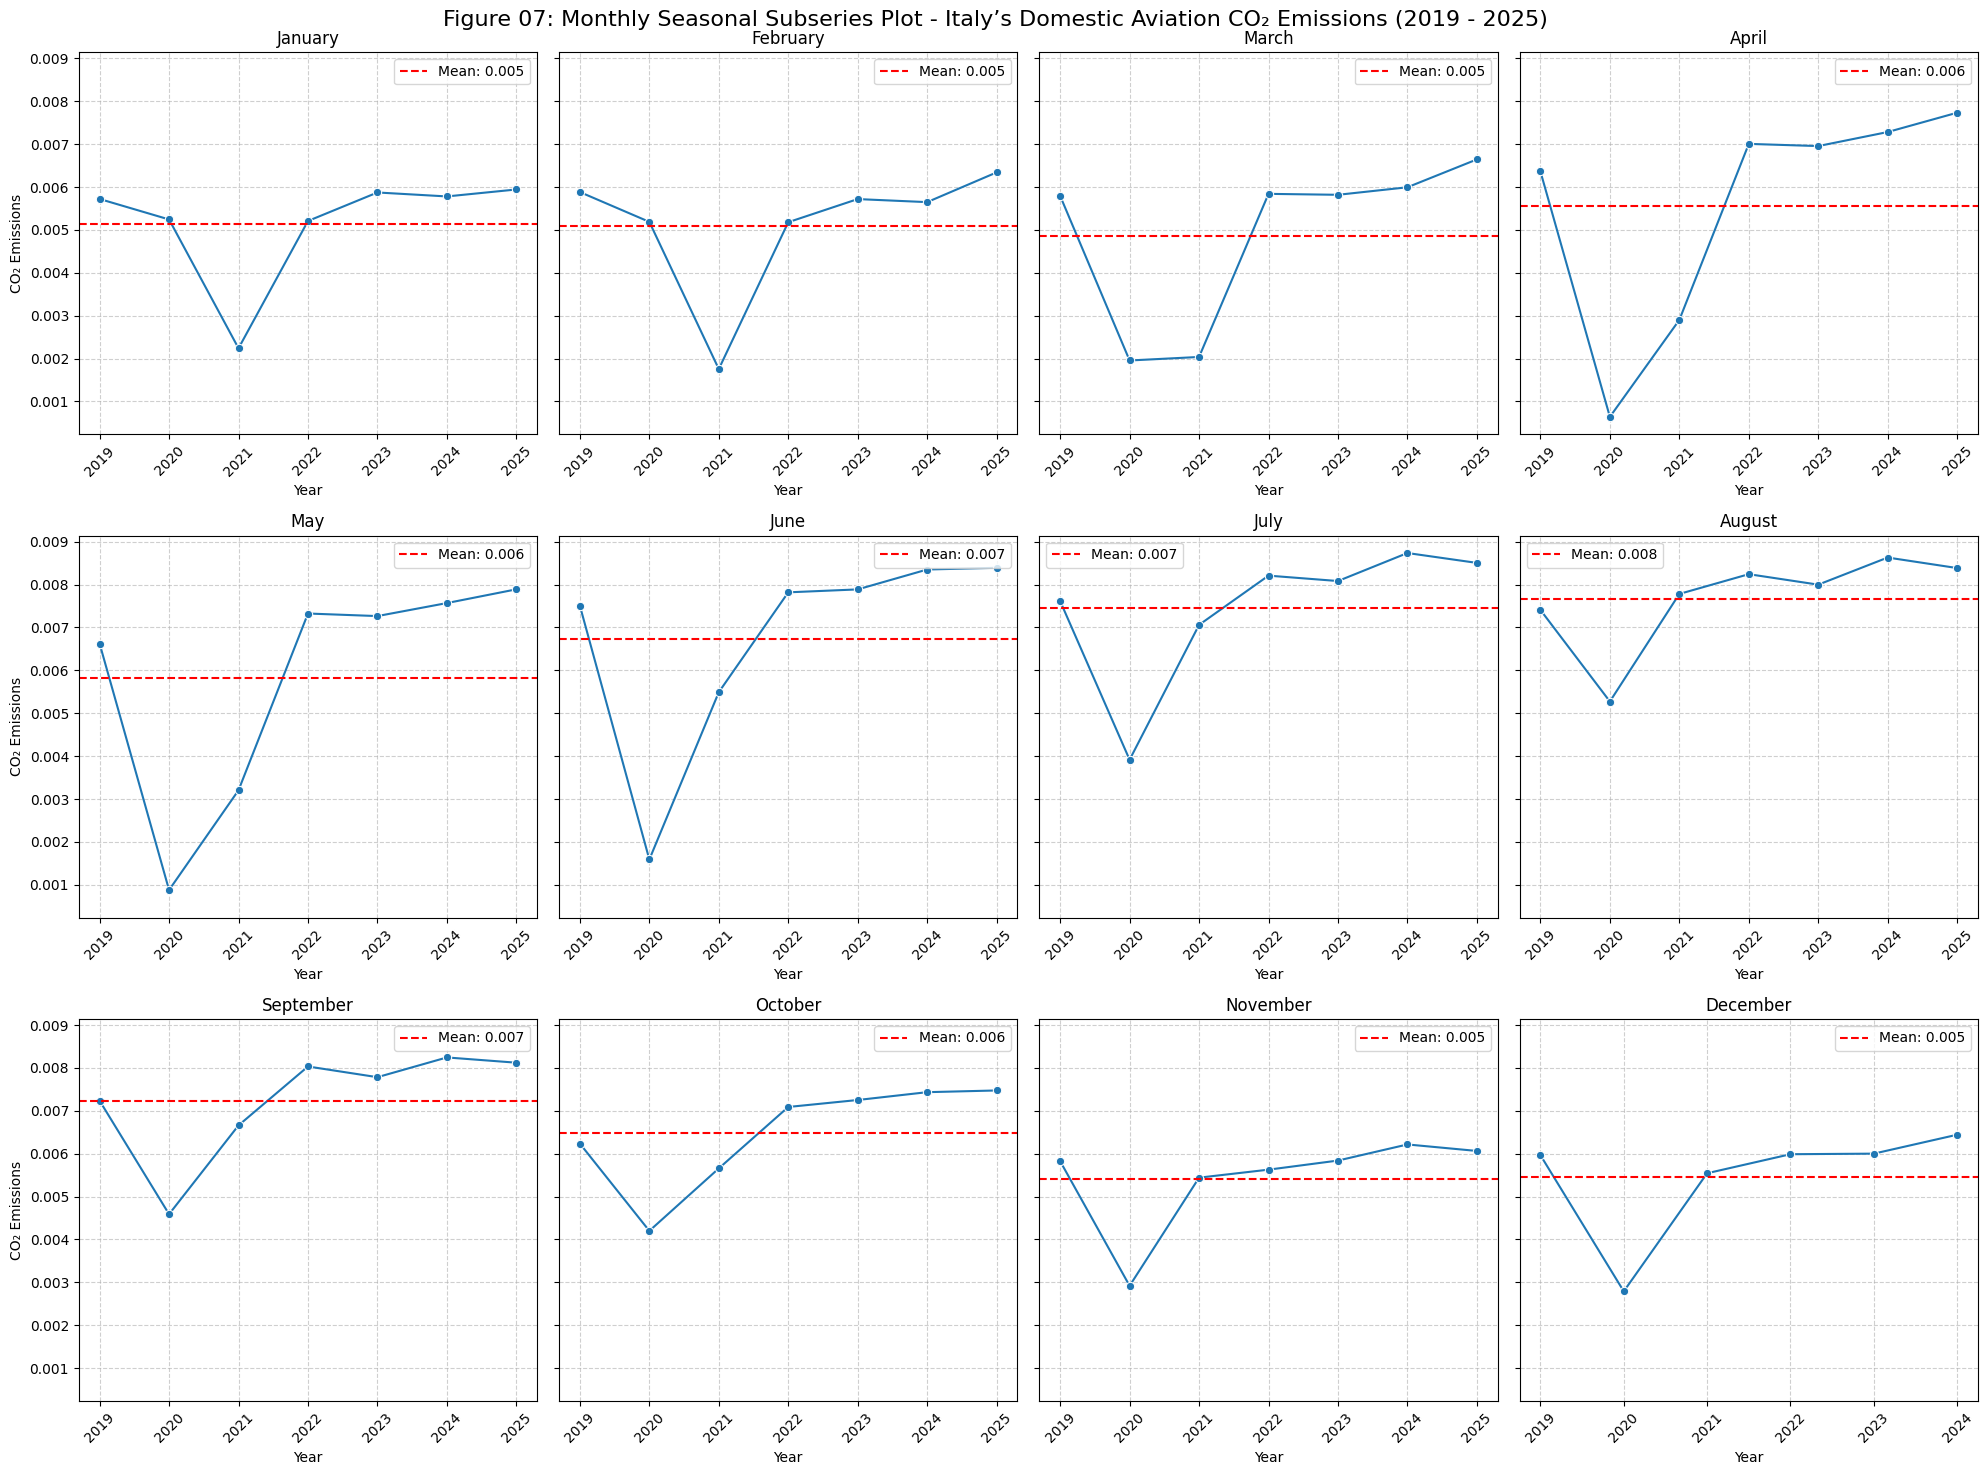

In [777]:
monthly_subseries_visualization(
    italy_domestic_aviation_df,
    month_field='month',
    year_field='year',
    emission_field='value',
    plot_title="Figure 07: Monthly Seasonal Subseries Plot - Italy’s Domestic Aviation CO₂ Emissions (2019 - 2025)"
)

In [778]:
display(len(italy_domestic_aviation_df))

2526

In [779]:
num_of_lags = round(np.sqrt(len(italy_domestic_aviation_df)))
display(num_of_lags)

50

In [780]:
ci_limit = 1.96 / np.sqrt(len(italy_domestic_aviation_df))
display(ci_limit, -ci_limit)

np.float64(0.03899773629664761)

np.float64(-0.03899773629664761)

In [781]:
def visualize_acf_with_fixed_bounds(data_series,
                                    lag_count=50,
                                    plot_heading="Autocorrelation Function (ACF)",
                                    conf_level=0.95):

    cleaned_series = data_series.dropna()

    total_obs = len(cleaned_series)

    if conf_level == 0.95:
        critical_z = 1.96
    elif conf_level == 0.99:
        critical_z = 2.576
    elif conf_level == 0.90:
        critical_z = 1.645
    else:
        raise ValueError("Allowed confidence levels: 0.90, 0.95, 0.99")

    bound_limit = critical_z / np.sqrt(total_obs)

    fig_container, axis_container = plt.subplots(figsize=(16, 8))

    plot_acf(
        cleaned_series,
        lags=lag_count,
        alpha=None,
        ax=axis_container
    )

    axis_container.axhline(bound_limit,
                           color='red',
                           linestyle='--',
                           linewidth=1.5,
                           label=f'+{int(conf_level*100)}% CI ({bound_limit:.3f})')

    axis_container.axhline(-bound_limit,
                           color='red',
                           linestyle='--',
                           linewidth=1.5,
                           label=f'-{int(conf_level*100)}% CI ({-bound_limit:.3f})')

    axis_container.set_title(plot_heading)
    axis_container.set_ylim(-1.05, 1.05)
    axis_container.legend()

    plt.tight_layout()
    plt.show()

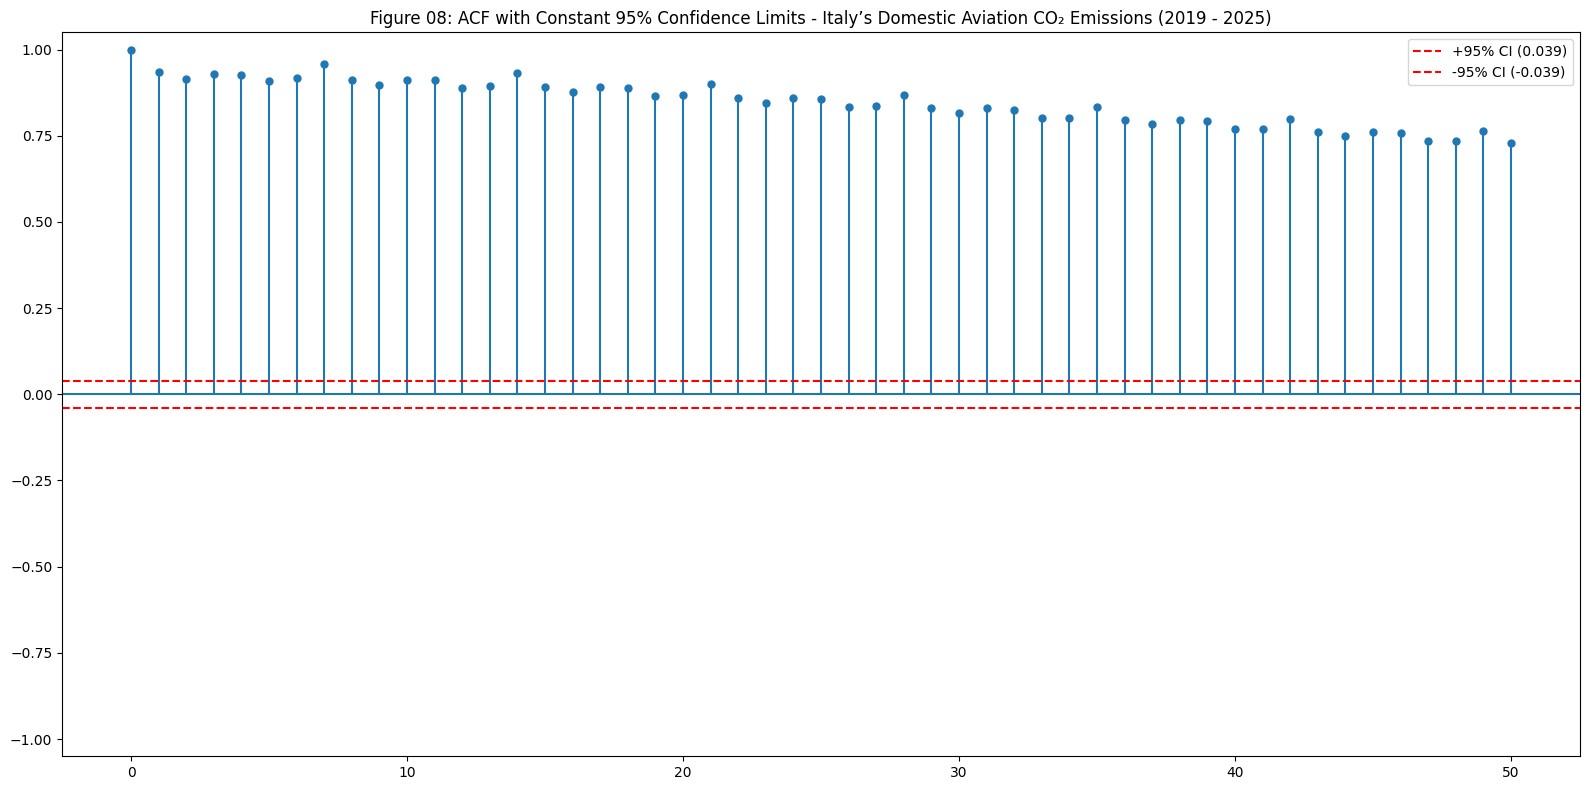

In [782]:
visualize_acf_with_fixed_bounds(
    italy_domestic_aviation_df["value"],
    lag_count=num_of_lags,
    plot_heading="Figure 08: ACF with Constant 95% Confidence Limits - Italy’s Domestic Aviation CO₂ Emissions (2019 - 2025)",
    conf_level=0.95
)

In [783]:
def visualize_time_series_with_moving_statistics(data_frame,
                                                  target_column="value",
                                                  moving_window=52,
                                                  figure_title="Rolling Statistics",
                                                  y_axis_label="CO₂ Emissions",
                                                  x_axis_label="Per Day",
                                                  figure_dimensions=(15, 8),
                                                  display_series=True,
                                                  display_mean=True,
                                                  display_std=True):

    cleaned_values = data_frame[target_column].dropna()

    fig_canvas, axis_canvas = plt.subplots(nrows=1, ncols=1, figsize=figure_dimensions)

    if display_series:
        sns.lineplot(
            x=cleaned_values.index,
            y=cleaned_values.values,
            ax=axis_canvas,
            color="blue",
            label="Observed Values"
        )

    if display_mean:
        moving_average = cleaned_values.rolling(moving_window).mean()
        sns.lineplot(
            x=moving_average.index,
            y=moving_average.values,
            ax=axis_canvas,
            color="red",
            label=f"Moving Average (Window={moving_window})"
        )

    if display_std:
        moving_std_dev = cleaned_values.rolling(moving_window).std()
        sns.lineplot(
            x=moving_std_dev.index,
            y=moving_std_dev.values,
            ax=axis_canvas,
            color="green",
            label=f"Moving Std Dev (Window={moving_window})"
        )

    axis_canvas.set_title(figure_title, fontsize=14)
    axis_canvas.set_ylabel(y_axis_label, fontsize=14)
    axis_canvas.set_xlabel(x_axis_label, fontsize=14)
    axis_canvas.legend()

    axis_canvas.set_xlim([cleaned_values.index.min(),
                          cleaned_values.index.max()])

    plt.tight_layout()
    plt.show()

In [784]:
moving_window = round(len(italy_domestic_aviation_df) * 10 / 100)
display(moving_window)

253

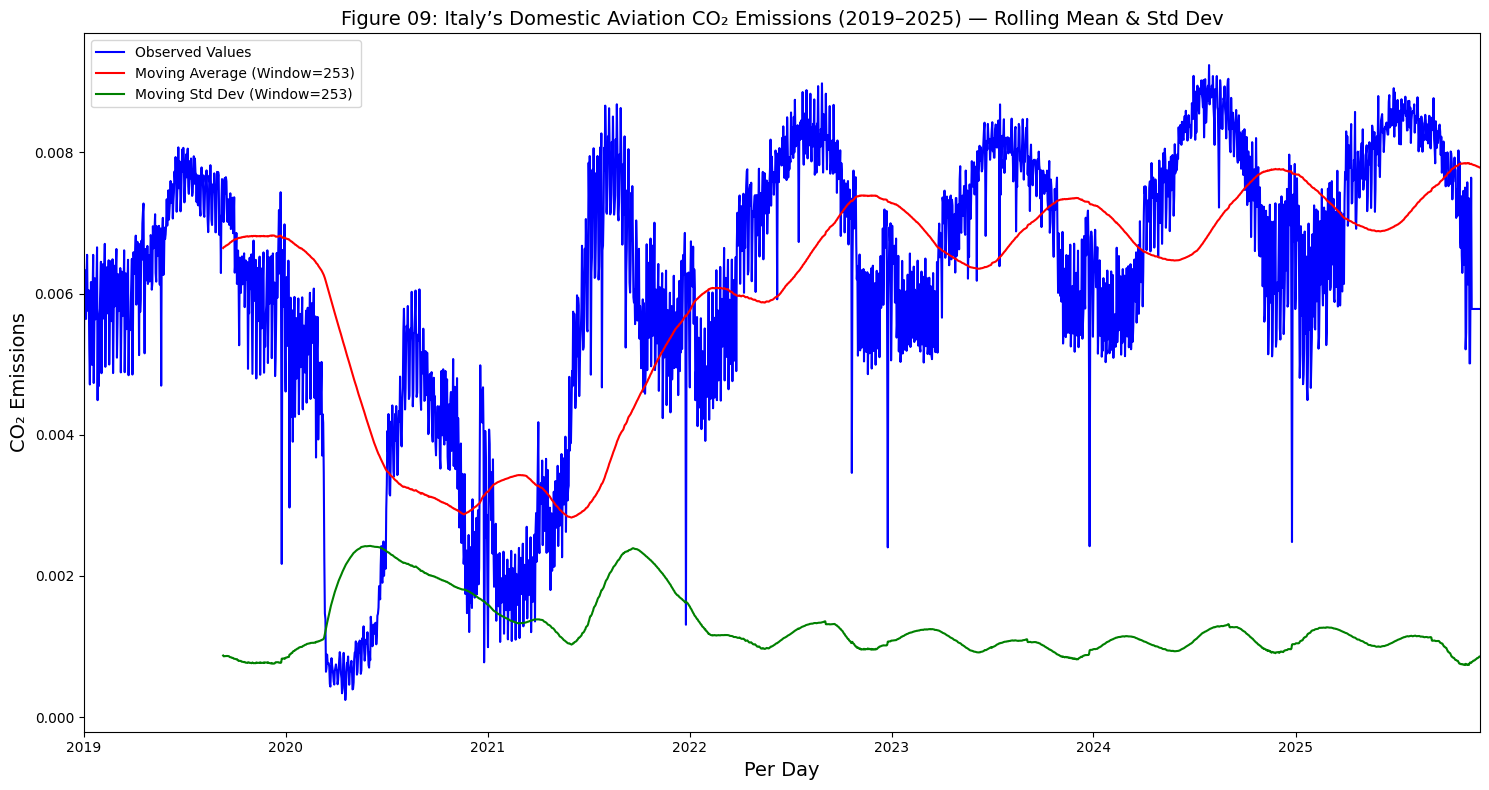

In [785]:
visualize_time_series_with_moving_statistics(
    data_frame=italy_domestic_aviation_df,
    target_column="value",
    moving_window=moving_window,
    figure_title="Figure 09: Italy’s Domestic Aviation CO₂ Emissions (2019–2025) — Rolling Mean & Std Dev"
)

In [786]:
def custom_boxplot_layout(data_frame,
                            feature_name="value",
                            main_title="Box Plot",
                            vertical_label="CO₂ Emissions",
                            canvas_size=(10, 7),
                            fill_color="#BFDCE5"):

    observations = data_frame[feature_name].dropna().to_numpy(dtype=float)

    if observations.size == 0:
        raise ValueError(f"No valid values found in column '{feature_name}'.")

    p25 = np.percentile(observations, 25)
    p50 = np.percentile(observations, 50)
    p75 = np.percentile(observations, 75)
    interquartile_span = p75 - p25

    lower_limit = p25 - 1.5 * interquartile_span
    upper_limit = p75 + 1.5 * interquartile_span

    whisker_min = np.min(observations[observations >= lower_limit])
    whisker_max = np.max(observations[observations <= upper_limit])

    extreme_low  = observations[observations < lower_limit]
    extreme_high = observations[observations > upper_limit]

    anomaly_total = extreme_low.size + extreme_high.size
    anomaly_ratio = 100.0 * anomaly_total / observations.size

    percent_below_p25 = 100.0 * np.mean(observations < p25)
    percent_above_p75 = 100.0 * np.mean(observations > p75)
    percent_below_p75 = 100.0 * np.mean(observations < p75)
    percent_middle    = 100.0 * np.mean((observations >= p25) & (observations <= p75))

    value_range = observations.max() - observations.min()
    offset = value_range * 0.07 if value_range > 0 else 1e-6

    fig_obj, axis_obj = plt.subplots(figsize=canvas_size)

    sns.boxplot(
        y=observations,
        ax=axis_obj,
        color=fill_color,
        width=0.35,
        linewidth=1,
        medianprops=dict(color='blue', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        flierprops=dict(
            marker='o',
            markerfacecolor='red',
            markeredgecolor='red',
            markersize=5,
            alpha=0.8
        )
    )

    axis_obj.set_title(main_title, fontsize=14, pad=18)
    axis_obj.set_ylabel(vertical_label, fontsize=12)
    axis_obj.set_xticks([])
    axis_obj.grid(axis="y", linestyle="--", alpha=0.25)

    summary_line = (
        f"Outliers: {anomaly_total} ({anomaly_ratio:.2f}%) | "
        f"Lower: {extreme_low.size} | Upper: {extreme_high.size}"
    )

    fig_obj.text(0.5, 0.93,
                 summary_line,
                 ha="center",
                 va="center",
                 fontsize=11,
                 color="red",
                 fontweight="bold")

    axis_obj.set_ylim(observations.min() - offset * 2.0,
                      observations.max() + offset * 3.0)

    axis_obj.text(0,
                  p50 + offset * 0.50,
                  f"Median (Q2) = {p50:.4f}",
                  ha="center",
                  va="center",
                  fontsize=11,
                  color="blue",
                  fontweight="bold")

    axis_obj.text(0,
                  p50 - offset * 0.80,
                  f"IQR = {interquartile_span:.4f}\n{percent_middle:.1f}% inside IQR",
                  ha="center",
                  va="center",
                  fontsize=10)

    def side_annotation(y_point, text_label, x_position, y_position):
        axis_obj.annotate(
            text_label,
            xy=(0, y_point),
            xytext=(x_position, y_position),
            textcoords="data",
            ha="left" if x_position > 0 else "right",
            va="center",
            fontsize=10,
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    right_anchor = 0.22
    left_anchor  = -0.22

    side_annotation(p75,
                    f"Q3 = {p75:.4f}\n{percent_below_p75:.1f}% below Q3",
                    right_anchor,
                    p75 + offset * 0.50)

    side_annotation(p25,
                    f"Q1 = {p25:.4f}\n{percent_below_p25:.1f}% below Q1",
                    right_anchor,
                    p25 - offset * 0.50)

    side_annotation(whisker_max,
                    f"Upper whisker = {whisker_max:.4f}",
                    left_anchor,
                    whisker_max + offset * 0.25)

    side_annotation(whisker_min,
                    f"Lower whisker = {whisker_min:.4f}",
                    left_anchor,
                    whisker_min - offset * 0.25)

    if extreme_low.size > 0:
        lowest_outlier_value = extreme_low.min()

        axis_obj.annotate(
            f"Lower outliers = {extreme_low.size}",
            xy=(0, lowest_outlier_value),
            xytext=(-0.28, lowest_outlier_value - offset * 0.8),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=10,
            color="black",
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    if extreme_high.size > 0:
        highest_outlier_value = extreme_high.max()

        axis_obj.annotate(
            f"Upper outliers = {extreme_high.size}",
            xy=(0, highest_outlier_value),
            xytext=(0.28, highest_outlier_value + offset * 0.8),
            textcoords="data",
            ha="left",
            va="center",
            fontsize=10,
            color="black",
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

    return {
        "Q1": p25,
        "Median": p50,
        "Q3": p75,
        "IQR": interquartile_span,
        "LowerWhisker": whisker_min,
        "UpperWhisker": whisker_max,
        "OutliersTotal": anomaly_total,
        "OutlierPercent": anomaly_ratio
    }

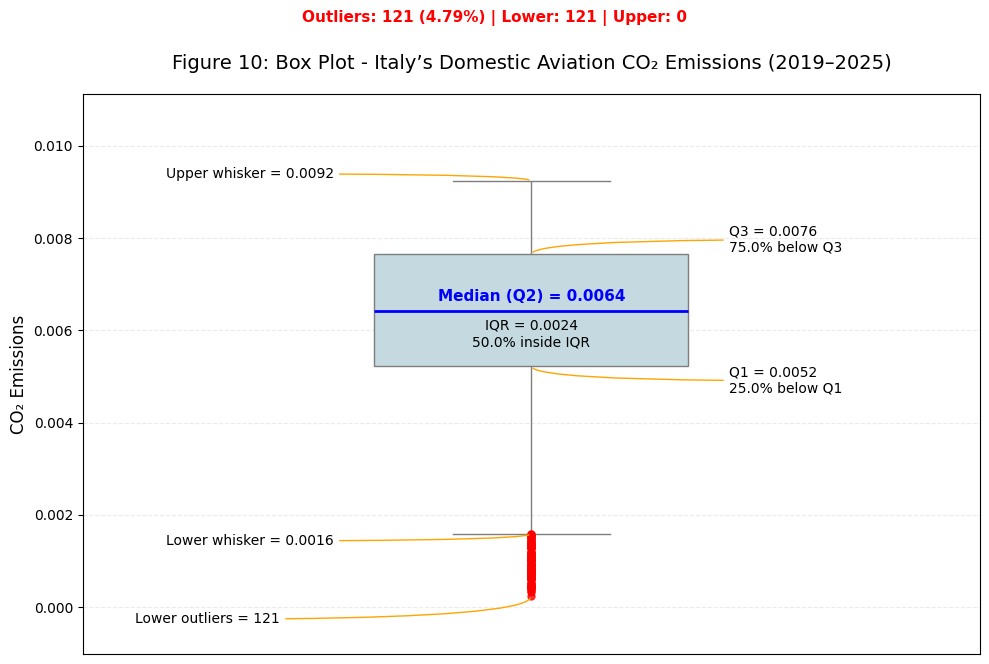

{'Q1': np.float64(0.0052255675),
 'Median': np.float64(0.006423655),
 'Q3': np.float64(0.0076482975),
 'IQR': np.float64(0.0024227299999999997),
 'LowerWhisker': np.float64(0.00159301),
 'UpperWhisker': np.float64(0.00923652),
 'OutliersTotal': 121,
 'OutlierPercent': 4.790182106096595}

In [787]:
custom_boxplot_layout(
    italy_domestic_aviation_df,
    feature_name="value",
    main_title="Figure 10: Box Plot - Italy’s Domestic Aviation CO₂ Emissions (2019–2025)"
)

In [788]:
italy_domestic_aviation_df['value'].describe()

,value
count,2526.000000
mean,0.006090
std,0.002010
min,0.000241
25%,0.005226
50%,0.006424
75%,0.007648
max,0.009237


In [789]:
def run_isolation_forest_detection(
    input_dataframe,
    target_feature="value",
    num_trees=100,
    sample_limit=256,
    anomaly_fraction=0.10,
    seed_value=42,
    max_tree_height=6,
    display_plot=True,
    figure_caption=""
):

    processed_df = input_dataframe.copy().sort_index()

    iso_model = IsolationForest(
        n_estimators=num_trees,
        max_samples=sample_limit,
        contamination=anomaly_fraction,
        random_state=seed_value
    )

    processed_df["anomaly"] = iso_model.fit_predict(
        processed_df[[target_feature]]
    )

    processed_df["anomaly_score"] = iso_model.decision_function(
        processed_df[[target_feature]]
    )

    processed_df["is_anomaly"] = processed_df["anomaly"] == -1

    detected_points = processed_df[processed_df["is_anomaly"]]
    anomaly_percentage = (len(detected_points) / len(processed_df)) * 100

    print(
        f"Isolation Forest detected {len(detected_points)} anomalies "
        f"({anomaly_percentage:.2f}% of total observations).\n"
    )

    return processed_df, anomaly_percentage

In [790]:
tree_count = 100
max_sample_size = round(0.1 * len(italy_domestic_aviation_df))
display(max_sample_size)

253

In [791]:
max_tree_height = round(np.log2(max_sample_size))
display(max_tree_height)

8

In [792]:
contamination_rate = 0.05

In [793]:
df_isolation_forest_output, anomaly_ratio = run_isolation_forest_detection(
    italy_domestic_aviation_df,
    target_feature="value",
    num_trees=tree_count,
    sample_limit=max_sample_size,
    anomaly_fraction=contamination_rate
)

Isolation Forest detected 126 anomalies (4.99% of total observations).



In [794]:
display(df_isolation_forest_output[df_isolation_forest_output['is_anomaly'] == True][['value','anomaly','anomaly_score','is_anomaly']].head())

,value,anomaly,anomaly_score,is_anomaly
date,,,,
2020-03-14,0.000641,-1,-0.017242,True
2020-03-15,0.000698,-1,-0.011017,True
2020-03-16,0.000885,-1,-0.012115,True
2020-03-17,0.000768,-1,-0.010035,True
2020-03-18,0.000760,-1,-0.009603,True


In [795]:
def visualize_anomaly_scores(
    input_df,
    score_column="anomaly_score",
    label_column="anomaly",
    time_axis=None,
    figure_title="Isolation Forest Anomaly Score Visualization",
    canvas_dim=(10, 5)
):

    data_copy = input_df.copy()

    if time_axis is None:
        time_axis = data_copy.index

    regular_points = data_copy[data_copy[label_column] == 1]

    abnormal_points = data_copy[data_copy[label_column] == -1]

    plt.figure(figsize=canvas_dim)

    plt.scatter(
        regular_points.index,
        regular_points[score_column],
        color="blue",
        label="Regular Observations",
        alpha=0.7
    )

    plt.scatter(
        abnormal_points.index,
        abnormal_points[score_column],
        color="red",
        label="Detected Anomalies",
        alpha=0.9
    )

    plt.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.6)

    plt.xlabel("Instances (CO2 Emissions)")
    plt.ylabel("Anamoly Score")
    plt.title(figure_title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

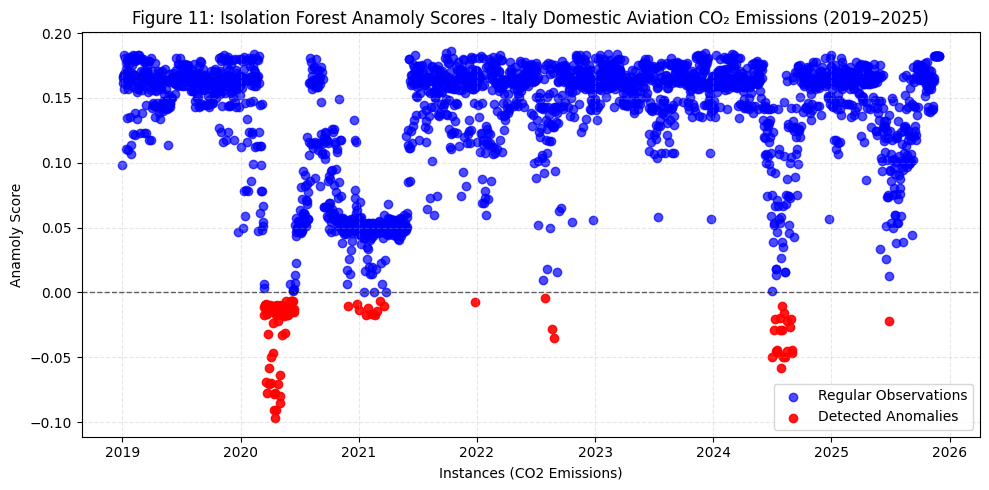

In [796]:
visualize_anomaly_scores(
    df_isolation_forest_output,
    score_column="anomaly_score",
    label_column="anomaly",
    figure_title="Figure 11: Isolation Forest Anamoly Scores - Italy Domestic Aviation CO₂ Emissions (2019–2025)"
)

In [797]:
# ============================================================
# 0) Reproducibility
# ============================================================
def initialize_random_state(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Baseline Scaling (fit on baseline, transform all)
# ============================================================
def scale_using_baseline(raw_series, baseline_cutoff, min_required_points):

    baseline_timestamp = pd.to_datetime(baseline_cutoff)
    baseline_mask = raw_series.index <= baseline_timestamp

    if baseline_mask.sum() < min_required_points:
        raise ValueError("Not enough baseline points.")

    values_2d = raw_series.values.reshape(-1, 1).astype(np.float64)

    baseline_mean = float(values_2d[baseline_mask].mean())
    baseline_std = float(values_2d[baseline_mask].std())

    print("Before Scaling (Baseline Only):")
    print("Baseline Mean:", baseline_mean)
    print("Baseline Std :", baseline_std)

    scaler = StandardScaler()
    scaler.fit(values_2d[baseline_mask])
    scaled_values = scaler.transform(values_2d)

    # Verify scaling on baseline portion
    scaled_series = pd.Series(scaled_values.flatten(), index=raw_series.index)
    print("\nAfter Scaling (Baseline Only):")
    print("Baseline Mean:", float(scaled_series[baseline_mask].mean()))
    print("Baseline Std :", float(scaled_series[baseline_mask].std()),"\n")

    return scaled_values, baseline_timestamp


# ============================================================
# 2) Sliding Windows
# ============================================================
def create_sequence_windows(scaled_values, index, window_length):
    windows = []
    for t in range(window_length - 1, len(scaled_values)):
        windows.append(scaled_values[t - window_length + 1 : t + 1])
    return np.stack(windows), index[window_length - 1:]


def extract_baseline_windows(all_windows, window_end_dates, baseline_timestamp):
    return all_windows[window_end_dates <= baseline_timestamp]


# ============================================================
# 3) LSTM Autoencoder
# ============================================================
class LSTMSequenceAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        context = hidden[-1]  # (batch, hidden_dim)
        repeated = context.unsqueeze(1).repeat(1, x.size(1), 1)  # (batch, seq_len, hidden_dim)
        decoded, _ = self.decoder(repeated)
        return self.output_layer(decoded)


# ============================================================
# 4) Train Model (baseline windows only)
# ============================================================
def train_lstm_autoencoder(baseline_windows, hidden_dim, epochs, batch_size, lr):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMSequenceAutoencoder(hidden_dim=hidden_dim).to(device)

    tensor_data = torch.tensor(baseline_windows, dtype=torch.float32)
    loader = DataLoader(
        TensorDataset(tensor_data, tensor_data),
        batch_size=batch_size,
        shuffle=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    epoch_mse_data = []

    model.train()
    for ep in range(1, epochs + 1):
        losses = []
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())

        epoch_mse_data.append([ep, np.mean(losses)])

    epoch_mse_df = pd.DataFrame(epoch_mse_data, columns=['EPOCH', 'MSE'])

    return model, epoch_mse_df


# ============================================================
# 5) Sequences DataFrame (input/output sequences + error per window)
# ============================================================
def compute_sequences_dataframe(model, all_windows, window_end_dates):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    tensor_data = torch.tensor(all_windows, dtype=torch.float32).to(device)

    with torch.no_grad():
        reconstructed = model(tensor_data).cpu().numpy()

    mse = np.mean((reconstructed - all_windows) ** 2, axis=(1, 2))

    df_sequences = pd.DataFrame(
        {
            "window_end_date": pd.to_datetime(window_end_dates),
            "input_sequence": list(all_windows.squeeze(-1)),
            "reconstructed_sequence": list(reconstructed.squeeze(-1)),
            "reconstruction_error": mse
        }
    ).set_index("window_end_date")

    return df_sequences


# ============================================================
# 6) Robust Z-score (baseline median + MAD)
# ============================================================
def compute_robust_zscore(reconstruction_error, baseline_cutoff, smooth_win):

    baseline_timestamp = pd.to_datetime(baseline_cutoff)

    smoothed = (reconstruction_error
                .rolling(smooth_win, center=True)
                .mean()
                .bfill()
                .ffill())

    baseline_values = smoothed[smoothed.index <= baseline_timestamp]

    median = float(baseline_values.median())
    mad = float(np.median(np.abs(baseline_values - median)))
    robust_sigma = 1.4826 * mad + 1e-12

    robust_z = (smoothed - median) / robust_sigma

    return smoothed, robust_z, median, robust_sigma


# ============================================================
# 7) Break Detection (persistent z-score)
# ============================================================
def detect_break_start_dates(z_score, z_threshold, min_consecutive_days):

    above = z_score > z_threshold

    persistent = (above.astype(int)
                  .rolling(min_consecutive_days)
                  .sum()
                  .ge(min_consecutive_days)
                  .fillna(False))

    break_dates = []
    inside = False

    for t, flag in persistent.items():
        if flag and not inside:
            start = t - pd.Timedelta(days=min_consecutive_days - 1)
            break_dates.append(pd.to_datetime(start))
            inside = True
        elif not flag:
            inside = False

    return break_dates


# ============================================================
# 8) Plot Results (final: NO window plot)
# ============================================================
def plot_results(reconstruction_error, smoothed_error, z_score,
                 break_dates, baseline_center, baseline_scale, z_threshold):

    # Plot 1: Reconstruction Error
    plt.figure(figsize=(16, 5))
    plt.plot(reconstruction_error, alpha=0.3, label="Raw Reconstruction Error")
    plt.plot(smoothed_error, linewidth=2, label="Smoothed Error")

    plt.axhline(
        baseline_center + z_threshold * baseline_scale,
        linestyle="--",
        linewidth=2,
        label="Detection Threshold"
    )

    for bd in break_dates:
        plt.axvline(bd, linestyle="--")

    plt.title("Reconstruction Error with Structural Break Detection")
    plt.xlabel("Date")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Robust Z-score
    plt.figure(figsize=(16, 4))
    plt.plot(z_score, linewidth=2, label="Robust Z-score")
    plt.axhline(z_threshold, linestyle="--", linewidth=2, label="Z Threshold")

    for bd in break_dates:
        plt.axvline(bd, linestyle="--")

    plt.title("Robust Z-score for Structural Break Detection")
    plt.xlabel("Date")
    plt.ylabel("Z-score")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 9) Final Pipeline (NO plotting inside)
# ============================================================
def detect_structural_breaks(
    dataframe,
    target_column="value",
    baseline_cutoff="2020-03-01",
    window_length=30,
    hidden_dim=64,
    epochs=30,
    batch_size=128,
    learning_rate=0.001,
    smoothing_window=7,
    z_threshold=3.0,
    min_consecutive_days=7,
    seed=42,
):

    initialize_random_state(seed)

    raw_series = dataframe[target_column].astype(np.float64).sort_index()

    scaled_values, baseline_timestamp = scale_using_baseline(
        raw_series,
        baseline_cutoff,
        min_required_points=window_length + 60
    )

    all_windows, window_end_dates = create_sequence_windows(
        scaled_values,
        raw_series.index,
        window_length
    )

    baseline_windows = extract_baseline_windows(
        all_windows,
        window_end_dates,
        baseline_timestamp
    )

    model, epoch_mse_df = train_lstm_autoencoder(
        baseline_windows=baseline_windows,
        hidden_dim=hidden_dim,
        epochs=epochs,
        batch_size=batch_size,
        lr=learning_rate
    )

    df_sequences = compute_sequences_dataframe(
        model=model,
        all_windows=all_windows,
        window_end_dates=window_end_dates
    )

    reconstruction_error = df_sequences["reconstruction_error"]

    smoothed_error, robust_z, center, scale = compute_robust_zscore(
        reconstruction_error=reconstruction_error,
        baseline_cutoff=baseline_cutoff,
        smooth_win=smoothing_window
    )

    df_sequences['smoothed_error'] = smoothed_error
    df_sequences['robust_z'] = robust_z

    break_dates = detect_break_start_dates(
        z_score=robust_z,
        z_threshold=z_threshold,
        min_consecutive_days=min_consecutive_days
    )

    return {
        "df_sequences": df_sequences,
        "reconstruction_error": reconstruction_error,
        "smoothed_error": smoothed_error,
        "robust_z": robust_z,
        "break_dates": break_dates,
        "baseline_center": center,
        "baseline_scale": scale,
        "z_threshold": z_threshold,
        "epoch_mse_df": epoch_mse_df
    }

In [798]:
results = detect_structural_breaks(
    dataframe=italy_domestic_aviation_df,
    target_column="value",
    baseline_cutoff="2020-03-01",
    window_length=30,
    hidden_dim=16,
    epochs=30,
    batch_size=64,
    learning_rate=0.001,
    smoothing_window=30,
    z_threshold=3.0,
    min_consecutive_days=7,
    seed=42,
)

Before Scaling (Baseline Only):
Baseline Mean: 0.00632942014084507
Baseline Std : 0.0009580602423823791

After Scaling (Baseline Only):
Baseline Mean: 8.339703471362678e-16
Baseline Std : 1.0011757793596836 



In [799]:
display(results['epoch_mse_df'].set_index('EPOCH').tail())

,MSE
EPOCH,
26,0.360631
27,0.343884
28,0.342720
29,0.343131
30,0.347571


In [800]:
print("Detected break dates:")
display(results["break_dates"])

Detected break dates:


[Timestamp('2019-12-24 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-10-02 00:00:00'),
 Timestamp('2021-09-17 00:00:00'),
 Timestamp('2021-12-21 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-08-05 00:00:00'),
 Timestamp('2022-10-25 00:00:00'),
 Timestamp('2022-12-24 00:00:00'),
 Timestamp('2023-12-25 00:00:00'),
 Timestamp('2024-06-28 00:00:00'),
 Timestamp('2024-12-15 00:00:00'),
 Timestamp('2025-06-21 00:00:00'),
 Timestamp('2025-11-13 00:00:00')]

In [801]:
results["df_sequences"]

,input_sequence,reconstructed_sequence,reconstruction_error,smoothed_error,robust_z
window_end_date,,,,,
2019-01-30,"[-1.9663065614335293, -0.13898931920391988, -0...","[-0.24118918, -0.42335898, -0.5498823, -0.6369...",0.447059,0.376209,0.682696
2019-01-31,"[-0.13898931920391988, -0.1182703715617135, -0...","[-0.22801018, -0.3994613, -0.5172633, -0.59735...",0.335753,0.376209,0.682696
2019-02-01,"[-0.1182703715617135, -0.0018476299994122744, ...","[-0.20576194, -0.35969055, -0.4634923, -0.5324...",0.345470,0.376209,0.682696
2019-02-02,"[-0.0018476299994122744, -0.7198922472035928, ...","[-0.22823483, -0.40169638, -0.52229524, -0.605...",0.364081,0.376209,0.682696
2019-02-03,"[-0.7198922472035928, -0.09408608859597502, 0....","[-0.23392147, -0.41142845, -0.53496003, -0.620...",0.360930,0.376209,0.682696
...,...,...,...,...,...
2025-11-26,"[0.22307559556326015, -0.03885991631642182, 0....","[-0.15572959, -0.27617222, -0.35760286, -0.411...",0.649945,0.686539,3.343283
2025-11-27,"[-0.03885991631642182, 0.21319103968559283, 1....","[-0.16166177, -0.28638092, -0.37091362, -0.427...",0.643027,0.686539,3.343283
2025-11-28,"[0.21319103968559283, 1.17444583271398, 0.0831...","[-0.16669965, -0.29504424, -0.38220486, -0.440...",0.633963,0.686539,3.343283


In [805]:
results["robust_z"]

,reconstruction_error
window_end_date,
2019-01-30,0.682696
2019-01-31,0.682696
2019-02-01,0.682696
2019-02-02,0.682696
2019-02-03,0.682696
...,...
2025-11-26,3.343283
2025-11-27,3.343283
2025-11-28,3.343283


In [802]:
results["smoothed_error"]

,reconstruction_error
window_end_date,
2019-01-30,0.376209
2019-01-31,0.376209
2019-02-01,0.376209
2019-02-02,0.376209
2019-02-03,0.376209
...,...
2025-11-26,0.686539
2025-11-27,0.686539
2025-11-28,0.686539


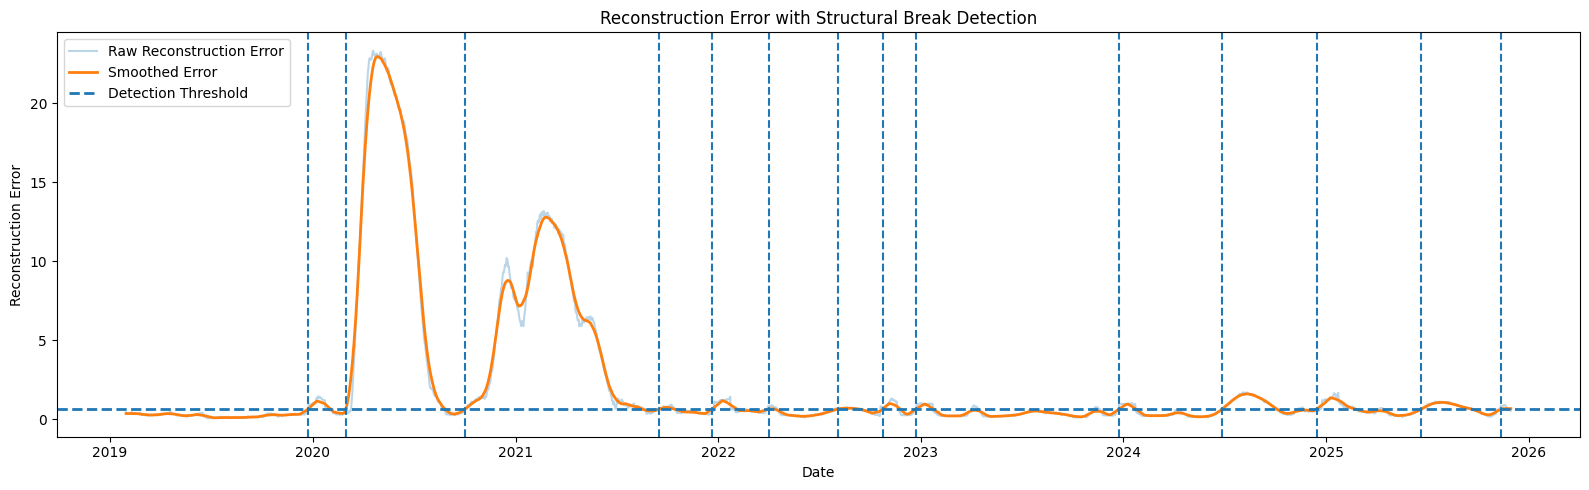

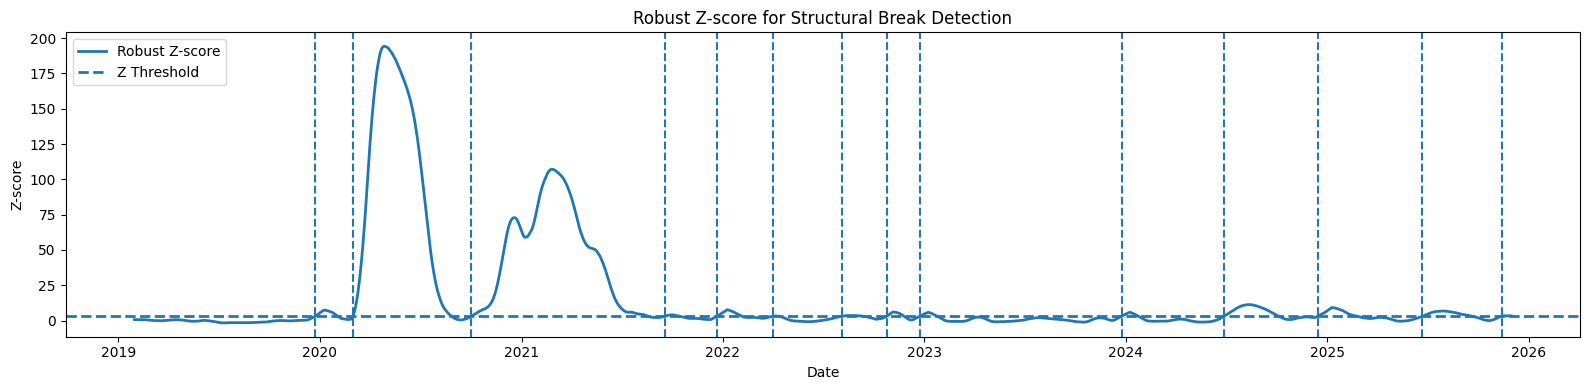

In [803]:
plot_results(
    reconstruction_error=results["reconstruction_error"],
    smoothed_error=results["smoothed_error"],
    z_score=results["robust_z"],
    break_dates=results["break_dates"],
    baseline_center=results["baseline_center"],
    baseline_scale=results["baseline_scale"],
    z_threshold=results["z_threshold"]
)

In [804]:
raise SystemExit("Execution stopped as requested.")

SystemExit: Execution stopped as requested.

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
country_df = df.copy()
country_domestic_aviation_df = country_df[country_df['sector'] == 'Domestic Aviation']
country_domestic_aviation_df = country_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
country_domestic_aviation_df.head()

In [ ]:
country_emissions = country_domestic_aviation_df.groupby('country')['value'].sum().reset_index()
country_emissions = country_emissions.rename(columns={'value': 'total_domestic_aviation_emissions'})

top_10_countries = country_emissions.sort_values(by='total_domestic_aviation_emissions', ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x='country', y='total_domestic_aviation_emissions', data=top_10_countries, palette='viridis', legend=False)
plt.title('Top 10 Countries by Total Domestic Aviation Emissions')
plt.xlabel('Country')
plt.ylabel('Total Domestic Aviation Emissions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
top_10_country_names = top_10_countries['country'].tolist()

country_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'].isin(top_10_country_names)]

print("DataFrame updated to include only top 10 countries by domestic aviation emissions.")

unique_countries_top_10 = country_domestic_aviation_df['country'].unique()
print("Unique Countries:")
for country in unique_countries_top_10:
    print(f"- {country}")



In [ ]:
country_record_counts = country_domestic_aviation_df.groupby('country').size().reset_index(name='record_count')

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='country', y='record_count', data=country_record_counts, palette='viridis', legend=False)
plt.title('Number of Records per Country in Domestic Aviation Data')
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
united_states_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United States'].copy()
china_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'China'].copy()
india_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'India'].copy()
russian_federation_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Russian Federation'].copy()
japan_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Japan'].copy()
brazil_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Brazil'].copy()
france_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'France'].copy()
spain_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Spain'].copy()
italy_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Italy'].copy()
united_kingdom_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United Kingdom'].copy()

In [ ]:
dfs = [
    united_states_domestic_aviation_df.assign(country='United States'),
    china_domestic_aviation_df.assign(country='China'),
    india_domestic_aviation_df.assign(country='India'),
    russian_federation_domestic_aviation_df.assign(country='Russian Federation'),
    japan_domestic_aviation_df.assign(country='Japan'),
    brazil_domestic_aviation_df.assign(country='Brazil'),
    france_domestic_aviation_df.assign(country='France'),
    spain_domestic_aviation_df.assign(country='Spain'),
    italy_domestic_aviation_df.assign(country='Italy'),
    united_kingdom_domestic_aviation_df.assign(country='United Kingdom')
]


In [ ]:
monthly = (
    country_domestic_aviation_df
    .set_index("date")
    .groupby("country")["value"]
    .resample("ME")
    .mean()
    .reset_index()
)
display(monthly.head())
display("Shape",monthly.shape)


In [ ]:
plt.figure(figsize=(18, 9))
sns.lineplot(data=monthly, x='date', y='value', hue='country', palette='tab10', linewidth=1.5)
plt.title('Domestic Aviation Emissions Over Time for Top 10 Countries', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Emissions Value', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
pivot = monthly.pivot_table(index="country", columns="date", values="value", aggfunc="mean")

print("Pivot shape (countries x time):", pivot.shape)
display(pivot.head(10))

In [ ]:
X = pivot.values.astype(float)
X_ts = X[:, :, None]
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_scaled = scaler.fit_transform(X_ts)

In [ ]:
pd.DataFrame(X_scaled[:, :, 0]).head(10)

In [ ]:
df_plot = pd.DataFrame(
    X_scaled[:, :, 0],
    index=pivot.index,
    columns=pivot.columns
)

plt.figure(figsize=(12,6))

for country in df_plot.index:
    plt.plot(df_plot.columns, df_plot.loc[country], label=country)

plt.title("Standardized CO2 Emissions Time Series")
plt.xlabel("Date")
plt.ylabel("Scaled Emissions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
k_values = range(2, 11)
inertias = []

for k in k_values:
    km = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
        max_iter=50,
        n_init=3,
        random_state=42,
        verbose=False
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster DTW sum)")
plt.title("Elbow Plot (DTW TimeSeriesKMeans)")
plt.xticks(list(k_values))
plt.grid(True)
plt.show()


In [ ]:
k = 3

dtw_km = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
    random_state=42,
    n_init=5,
    max_iter=50,
    verbose=False
)

dtw_labels = dtw_km.fit_predict(X_scaled)

cluster_df = pd.DataFrame({"country": pivot.index, "dtw_cluster": dtw_labels})
cluster_df = cluster_df.sort_values("dtw_cluster")

print("DTW clusters:")
display(cluster_df)


In [ ]:
for c in range(k):
    members = cluster_df[cluster_df["dtw_cluster"] == c]["country"].tolist()
    print(f"Cluster {c}: {members}")

In [ ]:
dates = pivot.columns

for c in range(k):
    members = np.where(dtw_labels == c)[0]
    plt.figure(figsize=(14, 5))
    for idx in members:
        plt.plot(dates, X_scaled[idx, :, 0], alpha=0.6, linewidth=1)

    center = dtw_km.cluster_centers_[c, :, 0]
    plt.plot(dates, center, linewidth=3, label="Cluster center")

    plt.title(f"DTW Cluster {c} (standardized emission trends)")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Standardized emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
centers = dtw_km.cluster_centers_[:, :, 0].astype(np.float64)

center_dist = np.zeros((k, k), dtype=np.float64)

for i in range(k):
    for j in range(k):
        center_dist[i, j] = dtw(
            centers[i],
            centers[j],
            global_constraint="itakura",
            itakura_max_slope=2.0
        )

plt.figure(figsize=(6, 5))
plt.imshow(center_dist)
plt.colorbar(label="DTW distance")
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.yticks(range(k), [f"C{i}" for i in range(k)])
plt.title("DTW distances between cluster centers")
plt.tight_layout()
plt.show()

In [ ]:
k = 4

dtw_km = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
    random_state=42,
    n_init=5,
    max_iter=50,
    verbose=False
)

dtw_labels = dtw_km.fit_predict(X_scaled)

cluster_df = pd.DataFrame({"country": pivot.index, "dtw_cluster": dtw_labels})
cluster_df = cluster_df.sort_values("dtw_cluster")

print("DTW clusters:")
display(cluster_df)

In [ ]:
for c in range(k):
    members = cluster_df[cluster_df["dtw_cluster"] == c]["country"].tolist()
    print(f"Cluster {c}: {members}")

In [ ]:
dates = pivot.columns

for c in range(k):
    members = np.where(dtw_labels == c)[0]
    plt.figure(figsize=(14, 5))
    for idx in members:
        plt.plot(dates, X_scaled[idx, :, 0], alpha=0.6, linewidth=1)

    center = dtw_km.cluster_centers_[c, :, 0]
    plt.plot(dates, center, linewidth=3, label="Cluster center")

    plt.title(f"DTW Cluster {c} (standardized emission trends)")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Standardized emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
centers = dtw_km.cluster_centers_[:, :, 0].astype(np.float64)

center_dist = np.zeros((k, k), dtype=np.float64)

for i in range(k):
    for j in range(k):
        center_dist[i, j] = dtw(
            centers[i],
            centers[j],
            global_constraint="itakura",
            itakura_max_slope=2.0
        )

plt.figure(figsize=(6, 5))
plt.imshow(center_dist)
plt.colorbar(label="DTW distance")
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.yticks(range(k), [f"C{i}" for i in range(k)])
plt.title("DTW distances between cluster centers")
plt.tight_layout()
plt.show()